# 🧊 The Case of the Melting Mystery: Who’s Stealing the Ice Cream?

## 🎯 Project Goal
The goal of this project is to build a deep learning pipeline using **Convolutional Autoencoders (CAEs)** to **denoise low-quality surveillance images** and reconstruct clear facial images of individuals captured in noisy conditions. The application aims to simulate how intelligent vision systems can be used to identify individuals even when images are distorted, blurred, or noisy — a relevant challenge in real-world scenarios like home security or low-end surveillance systems.

---

## 🏠 Business Context: The Midnight Ice Cream Mystery

In our fictional yet relatable setup, six housemates live together peacefully — until **someone starts stealing ice cream at night**. The only clue? Images captured by a **low-resolution fridge cam** that operates in poor lighting and records **grainy, noisy images**.

The challenge is:  
- These images are **too corrupted** for the human eye to reliably identify who's who.
- Traditional filtering techniques don’t cut it — they blur faces and remove key identity traits.
- We need a model that can **learn from data** to reconstruct the most likely clean version of a noisy face.

Thus, we turn to **Convolutional Autoencoders** — a type of neural network that compresses and reconstructs images — to clean up the noise and potentially catch our ice cream thief.

---

## 🧾 Dataset Details

To simulate the six housemates, we used facial images from the **Labeled Faces in the Wild (LFW)** dataset — a well-known collection of real-world celebrity images often used in face recognition tasks.

- We selected **6 individuals**, each with **at least 30 images**.
- Images were resized to **64×64 RGB format** to suit our CAE architecture and reduce computational cost.
- All images were **normalized** and augmented using torchvision’s transformation pipeline.
- We added **Gaussian noise** to simulate the blurry, distorted effect of a poor-quality fridge cam.

To push our experiments further, we later used a **second dataset (VGGFace2)** with **400 images per person**, and larger image size (128×128), to test how dataset size and resolution impact model performance.

---

## ❓ Problem Definition & Model Justification

The core problem:  
> “Can we train a model to reconstruct clean, high-quality facial images from heavily noisy inputs?”

We chose **Convolutional Autoencoders (CAEs)** for the following reasons:
- They are **unsupervised**, requiring only image pairs (no labels).
- The encoder compresses noisy images into **meaningful latent representations**.
- The decoder learns to **restore structure and details**, filtering out noise naturally.
- They’re ideal for **denoising tasks**, especially when no perfect restoration formula exists.

We experimented with multiple model variants:
- A simple 3-layer CAE baseline,
- Two improved models using BatchNorm and Dropout,
- A final, deeper CAE trained on higher-resolution images from a larger dataset.

---

## ✅ Scope and Feasibility

This project is intentionally scoped to explore the **core functionality and design trade-offs** of denoising autoencoders:
- We work with relatively small image sizes (64×64 and 128×128).
- We limit the dataset to a few individuals to allow training on standard GPUs.
- We monitor model behavior across architectures, noise levels, and data sizes using **Weights & Biases (W&B)** sweeps.

The project is designed to be **feasible within course constraints**, while still demonstrating **deep learning principles**, effective model evaluation, and **practical use cases** in privacy-friendly home surveillance.

---

Let the investigation begin. 🍦🔍


# 📁 Step 1: Load the Dataset

Our image dataset is zipped up and ready to go. In this step, we extract the dataset to a local folder so we can load it for preprocessing.

We check if the folder `Final_Dataset/` already exists to avoid unzipping multiple times unnecessarily. If it doesn’t, we unzip `FinalDataset.zip` and get everything ready for training.

Let the digital detective work begin!


In [ ]:
# Step 1: Unzip the dataset
import zipfile
import os

# Path to the zip file
zip_path = "FinalDataset.zip"

# Path to extract the dataset
extract_path = "./Final_Dataset"

# Unzip only if the folder doesn't already exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("Dataset unzipped successfully!")
else:
    print("Dataset already unzipped.")


Dataset unzipped successfully!


#🧹 Step 2: Preprocess the Face Dataset with Train-Test Split

Now that our dataset is unzipped and ready, it's time to clean it up and split it for training and evaluation.

- We resize each image to a fixed size of **64x64 pixels** and convert it into a normalized tensor.
- Using `ImageFolder`, we load the RGB face images from our dataset folder.
- We apply a **train-test split** (80-20) so the model can train on a majority of the data and be tested on unseen samples.
- The `DataLoader` prepares mini-batches of data that are shuffled for training but kept in order for testing.

This gives us a solid foundation for training a denoising Convolutional Autoencoder while ensuring we can evaluate generalization.


In [ ]:
# Step 2 Load and preprocess the face dataset with a train-test split

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Image parameters
IMG_SIZE = 64
BATCH_SIZE = 32
TEST_SPLIT = 0.2  # 20% test

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # Converts to tensor in [0, 1]
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root="./Final_Dataset", transform=transform)

# Split into train and test sets
total_size = len(dataset)
test_size = int(TEST_SPLIT * total_size)
train_size = total_size - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Peek at a batch
images, labels = next(iter(train_loader))
print(f"Sample batch shape from train_loader: {images.shape}")  # [BATCH_SIZE, 3, 64, 64]


Total samples: 302
Training samples: 242
Test samples: 60
Sample batch shape from train_loader: torch.Size([32, 3, 64, 64])


# 👀 Step 3: Visualize Clean Images from Train and Test Sets

Before we dive into noisy data or model training, it's important to visually inspect the clean images from both the **training** and **test** sets.

### Why Are We Doing This?

- **Sanity check** 🧠 — We want to ensure the data was loaded and split correctly.
- **Visual consistency** 👁 — Images across sets should have consistent lighting, resolution, and alignment.
- **Debugging aid** 🛠 — If anything looks off now, it'll definitely affect training later.

### What We Did:
- We pulled one batch of images each from the train and test sets.
- The **top row** shows clean training images.
- The **bottom row** shows clean testing images.
- This lets us confirm that both splits contain reasonable samples with a good variety.




Sample Images from Train and Test Sets:


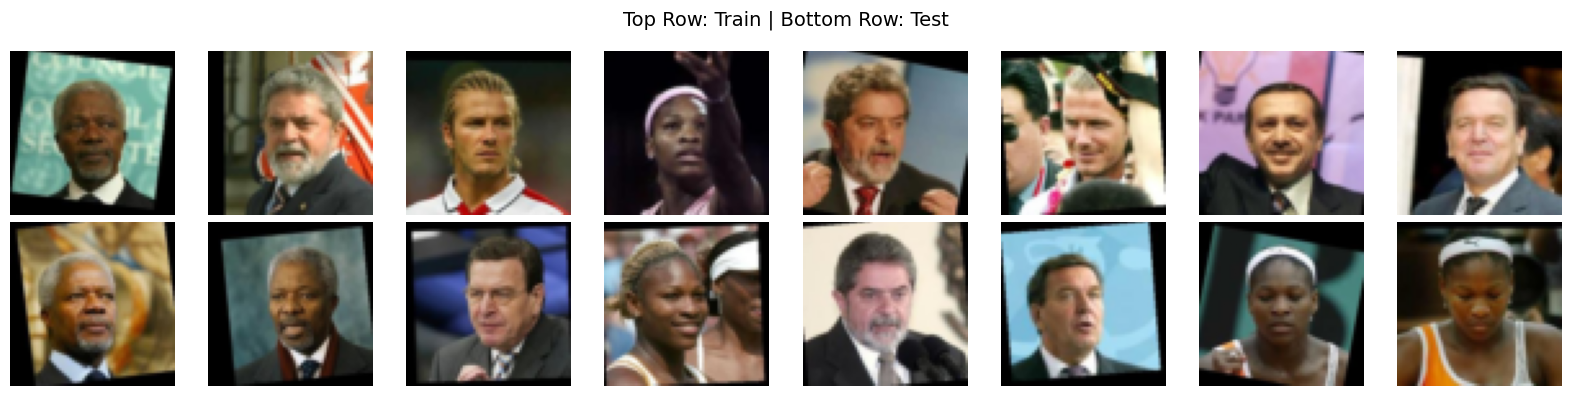

In [ ]:
# Step 3 Display a few clean face images from both train and test sets

import matplotlib.pyplot as plt
import numpy as np

# Helper function stays the same
def imshow_tensor(img_tensor):
    """Displays a single RGB image tensor (C, H, W)."""
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # C x H x W → H x W x C
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')


# Get a sample batch from each loader
train_images, _ = next(iter(train_loader))
test_images, _ = next(iter(test_loader))

# Display both sets side by side
print("Sample Images from Train and Test Sets:")
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle("Top Row: Train | Bottom Row: Test", fontsize=14)

for i in range(8):
    # Train image
    axs[0, i].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[0, i].axis('off')

    # Test image
    axs[1, i].imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


# 🌪️ Step 4: Add Gaussian Noise to Train and Test Images

To simulate the poor-quality thief cam images from our fridge scenario, we add **Gaussian noise** to the clean face images. This mimics blur, static, or graininess — which our Convolutional Autoencoder will later learn to clean up.

### What is Gaussian Noise?

- Gaussian noise adds random variation to each pixel, drawn from a **normal distribution**.
- It's controlled by a parameter called `noise_factor`, where higher values mean more corruption.
- In our case, we used a noise factor of **0.3** — enough to blur features but still preserve identity hints.

### Why Add Noise to Both Sets?

- **Train set**: The model learns to denoise these corrupted images by comparing them with their clean originals.
- **Test set**: We evaluate how well the model generalizes to new unseen noisy faces.

### Visualization Breakdown

- **Top Row**: Clean training images — the ground truth.
- **Middle Row**: Noisy training images — what the model sees.
- **Bottom Row**: Noisy test images — used later to evaluate reconstruction quality.

This gives us a great visual baseline before we throw a model at the problem.


Noise Visualization with Noise Factor = 0.3


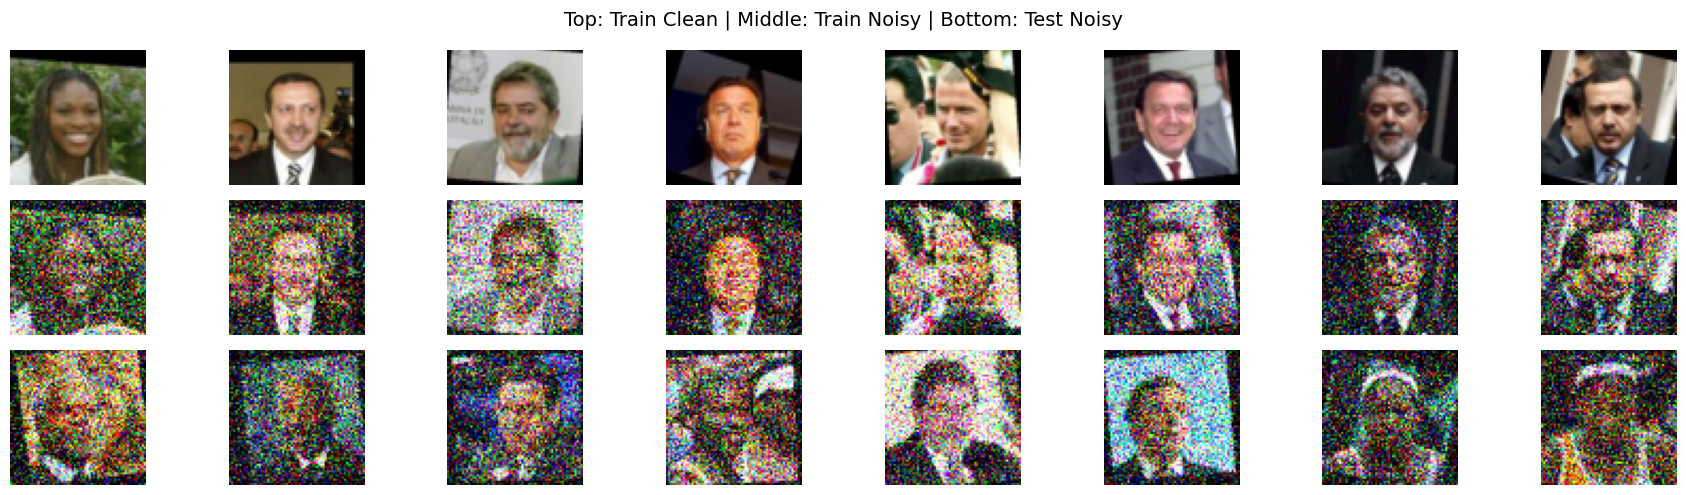

In [ ]:
# Step 4 Add Gaussian noise to images from both sets

import torch

# Set default noise factor
NOISE_FACTOR = 0.3

def add_noise(images, noise_factor=NOISE_FACTOR):
    """Adds Gaussian noise to RGB images."""
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy, 0., 1.)

# Grab sample batches
train_images, _ = next(iter(train_loader))
test_images, _ = next(iter(test_loader))

# Add noise
train_noisy = add_noise(train_images, noise_factor=NOISE_FACTOR)
test_noisy = add_noise(test_images, noise_factor=NOISE_FACTOR)

# Display both sets
print(f"Noise Visualization with Noise Factor = {NOISE_FACTOR}")

fig, axs = plt.subplots(3, 8, figsize=(18, 5))
fig.suptitle("Top: Train Clean | Middle: Train Noisy | Bottom: Test Noisy", fontsize=14)

for i in range(8):
    axs[0, i].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[0, i].axis('off')

    axs[1, i].imshow(np.transpose(train_noisy[i].numpy(), (1, 2, 0)))
    axs[1, i].axis('off')

    axs[2, i].imshow(np.transpose(test_noisy[i].numpy(), (1, 2, 0)))
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()


# 🧠 Step 5: Define the Convolutional Autoencoder (CAE)

Now that we've got noisy images, it's time to introduce our secret weapon: a **Convolutional Autoencoder (CAE)** — a type of neural network that learns to **compress** and **reconstruct** images, making it perfect for denoising tasks.

### 🏗️ Architecture Overview

Our CAE has two main parts:

---

### 🔒 **Encoder**
The encoder takes in a noisy 64×64 RGB image and compresses it down into a compact **latent representation** (like the network's memory of the clean version).

Layer Breakdown:
- `Conv2d → ReLU → MaxPool` (3 blocks):
  - Extracts increasingly abstract features (edges → textures → shapes).
  - MaxPooling progressively reduces spatial dimensions: 64×64 → 32×32 → 16×16 → 8×8.
- `Flatten + Linear`:
  - Flattens the final feature map and projects it to a **latent vector** of size `128` — this is where the image gets squeezed into a compressed "memory."

---

### 🔓 **Decoder**
The decoder takes the latent vector and attempts to **reconstruct** the original clean image.

Layer Breakdown:
- `Linear → Reshape`:
  - Re-expands the latent vector to match the 8×8×128 feature map dimensions.
- `ConvTranspose2d → ReLU` (3 blocks):
  - Gradually upsamples the feature map using **transposed convolutions** (also called deconvolutions).
  - Finally, a `Sigmoid` squashes output pixels back into `[0, 1]` range.

---

### 📌 Key Design Choices
- **Latent Vector Dimension = 128**:
  - A sweet spot for compressing image features without losing identity.
- **3 Encoder/Decoder Layers**:
  - Enough depth to learn high-level features without overfitting.
- **Sigmoid Output**:
  - Ensures reconstructed images remain visually valid (pixel values stay within 0–1).

---

With this CAE, we hope the network learns a **denoising mapping** — one that takes in blurry thief-cam faces and gives back clean ones!


In [ ]:
# Step 5: Define CAE with Latent Vector

import torch
import torch.nn as nn

LATENT_VECTOR_DIM = 128

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_vector_dim=LATENT_VECTOR_DIM):
        super(ConvAutoencoder, self).__init__()

        # --- Encoder ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # → (B, 32, 64, 64)
        self.relu1 = nn.ReLU(True)
        self.pool1 = nn.MaxPool2d(2, 2)                           # → (B, 32, 32, 32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # → (B, 64, 32, 32)
        self.relu2 = nn.ReLU(True)
        self.pool2 = nn.MaxPool2d(2, 2)                           # → (B, 64, 16, 16)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # → (B, 128, 16, 16)
        self.relu3 = nn.ReLU(True)
        self.pool3 = nn.MaxPool2d(2, 2)                           # → (B, 128, 8, 8)

        self.flattened_size = 128 * 8 * 8

        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(self.flattened_size, latent_vector_dim)

        # --- Decoder ---
        self.fc_decode = nn.Linear(latent_vector_dim, self.flattened_size)

        self.t_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # → (B, 64, 16, 16)
        self.relu4 = nn.ReLU(True)

        self.t_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)   # → (B, 32, 32, 32)
        self.relu5 = nn.ReLU(True)

        self.t_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)    # → (B, 3, 64, 64)
        self.output_activation = nn.Sigmoid()  # To scale outputs to [0, 1]

    def encode(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        latent = self.fc_encode(x)
        return latent

    def decode(self, latent):
        x = self.fc_decode(latent)
        x = x.view(-1, 128, 8, 8)  # Reshape to feature map before deconv
        x = self.relu4(self.t_conv1(x))
        x = self.relu5(self.t_conv2(x))
        x = self.output_activation(self.t_conv3(x))
        return x

    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed, latent

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)

print("CAE model:")
print(model)


CAE model:
ConvAutoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_encode): Linear(in_features=8192, out_features=128, bias=True)
  (fc_decode): Linear(in_features=128, out_features=8192, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (relu4): ReLU(inplace=True)
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (relu5): ReLU(inplace=True)
  (t

#🔁 Step 6: Define W&B Sweep Configuration (40 Epochs)

To explore which combinations of hyperparameters yield the best denoising performance, we set up a **Weights & Biases (W&B) Sweep**. This automates the experimentation process by running multiple training jobs with different parameter settings.

---

### 🧪 Sweep Strategy

- **Method**: `random`
  - Instead of testing every combination (which can be expensive), we randomly sample from the defined options.
  
- **Objective Metric**: `best_val_mse`
  - Our sweep aims to **minimize** the **Mean Squared Error** (MSE) on the validation set — lower MSE means better reconstructions.

---

### 🧷 Sweep Parameters

| Parameter           | Values                                  | Purpose                                                  |
|---------------------|------------------------------------------|----------------------------------------------------------|
| `latent_vector_dim` | `[64, 128, 256]`                         | Controls compression strength of the encoder.            |
| `learning_rate`     | `[1e-3, 1e-4]`                           | Affects training speed and convergence.                 |
| `noise_factor`      | `[0.1, 0.2, 0.3]`                        | Controls how much noise is added to training images.     |
| `batch_size`        | `[32, 64]`                               | Impacts memory usage and gradient quality.               |
| `epochs`            | `40` (fixed)                             | Trains for 40 passes over the dataset.                   |
| `model_type`        | `"CAE"`                                  | Just for metadata tagging in W&B dashboard.              |

---

### ✅ Why This Matters

Instead of manually guessing the best setup, this sweep helps us **let the data decide** which configuration works best. After a few runs, we'll be able to identify the most promising model setup based on the validation performance.


In [ ]:
# Step 6 (updated): Define W&B Sweep Configuration for CAE with 40 Epochs

sweep_config = {
    'method': 'random',
    'name': 'CAE_sweep_40epochs',
    'metric': {
        'name': 'best_val_mse',
        'goal': 'minimize'
    },
    'parameters': {
        'latent_vector_dim': {
            'values': [64, 128, 256]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'noise_factor': {
            'values': [0.1, 0.2, 0.3]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'epochs': {
            'value': 40
        },
        'model_type': {
            'value': 'CAE'
        }
    }
}


# Step 7: W&B-enabled Training Function for CAE

This step defines our main `train()` function, which handles everything from training to evaluation — while seamlessly integrating with **Weights & Biases (W&B)** for experiment tracking and artifact logging.

---

### 💡 What This Function Does:

1. **W&B Initialization**
   - Initializes a new run under the project `GoTG_Assignment07_AE`.
   - Tags the run with a unique ID and sets up model tracking with `wandb.watch()`.

2. **Hyperparameter Extraction**
   - Pulls parameters such as `latent_vector_dim`, `batch_size`, `learning_rate`, `noise_factor`, and `epochs` from the sweep configuration.

3. **Model Setup**
   - Dynamically constructs the **Convolutional Autoencoder (CAE)** based on the sweep’s chosen `latent_vector_dim`.
   - Sets up the optimizer (Adam) and loss function (MSELoss).

4. **Training Loop**
   - Trains for the specified number of epochs.
   - At each epoch:
     - Adds Gaussian noise to training images.
     - Performs forward + backward passes.
     - Tracks and logs MSE, MAE, and R² metrics to W&B.
   - Also keeps track of the **best model** (lowest validation loss) during training.

5. **Visualization & Logging**
   - Logs a **training loss curve**.
   - Logs side-by-side visual comparisons of:
     - Clean images
     - Noisy images
     - Reconstructed outputs

6. **Model Saving & Artifact Logging**
   - Saves the best-performing model weights locally.
   - Uploads the `.pth` file as a **W&B Artifact**, allowing easy retrieval later.

7. **Test Set Evaluation**
   - Runs inference on the test set (which the model hasn’t seen during training).
   - Logs test set metrics (MSE, MAE, R²) to W&B.

8. **Wraps up Cleanly**
   - Calls `wandb.finish()` to close the run gracefully and make sure all logs sync.

---

### ✅ Why This Matters

With this modular training function, each W&B sweep run:
- Trains the CAE on a unique hyperparameter combo
- Logs rich visual and numerical diagnostics
- Automatically saves the best model version
- Evaluates test performance to check for overfitting

This sets us up beautifully for comparing runs and selecting the best configuration for our noisy-fridge-camera thief problem 😎🍦.


In [ ]:
import wandb
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score
import copy
import os

def train():
    # Initialize W&B
    run = wandb.init(project="GoTG_Assignment07_AE", entity="usf-guardians")
    wandb.run.name = f"CAE_{run.id}"
    wandb.run.save()

    # Get sweep config
    config = wandb.config
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    noise_factor = config.noise_factor
    latent_dim = config.latent_vector_dim
    epochs = config.epochs

    # DataLoaders (use train_loader and test_loader set up earlier)
    global train_loader, test_loader  # These should have been split in step 2
    model = ConvAutoencoder(latent_vector_dim=latent_dim).to(device)
    wandb.watch(model, log="all")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_model = None
    best_val_loss = float('inf')
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for clean_images, _ in train_loader:
            noisy_images = add_noise(clean_images, noise_factor)
            noisy = noisy_images.to(device)
            clean = clean_images.to(device)

            optimizer.zero_grad()
            outputs, _ = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * clean.size(0)
            all_preds.append(outputs.detach().cpu())
            all_targets.append(clean.cpu())

        avg_loss = running_loss / len(train_loader.dataset)
        preds = torch.cat(all_preds).numpy().reshape(-1, 3 * 64 * 64)
        targets = torch.cat(all_targets).numpy().reshape(-1, 3 * 64 * 64)
        mae = mean_absolute_error(targets, preds)
        r2 = r2_score(targets, preds)

        wandb.log({
            "epoch": epoch + 1,
            "train_mse": avg_loss,
            "train_mae": mae,
            "train_r2": r2
        })

        epoch_losses.append(avg_loss)

        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            best_model = copy.deepcopy(model.state_dict())

    # Log best model metrics
    wandb.log({"best_val_mse": best_val_loss})

    # Plot and log loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    wandb.log({"loss_curve": wandb.Image(plt)})

    # Log comparison image grid
    model.eval()
    sample_images, _ = next(iter(train_loader))
    sample_noisy = add_noise(sample_images, noise_factor).to(device)
    with torch.no_grad():
        sample_recon, _ = model(sample_noisy)

    img_grid = []
    for i in range(6):
        img_grid.extend([
            sample_images[i],
            sample_noisy[i].cpu(),
            sample_recon[i].cpu().detach()
        ])
    wandb.log({"comparison_grid": [wandb.Image(img) for img in img_grid]})

    # Save and log model artifact to W&B
    model_path = "best_cae_model.pth"
    torch.save(best_model, model_path)

    artifact = wandb.Artifact("best_cae_model", type="model")
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    # Evaluate on test set
    all_test_preds, all_test_targets = [], []
    total_test_loss = 0.0

    with torch.no_grad():
        for clean_images, _ in test_loader:
            noisy_images = add_noise(clean_images, noise_factor).to(device)
            clean_images = clean_images.to(device)
            outputs, _ = model(noisy_images)
            loss = criterion(outputs, clean_images)

            total_test_loss += loss.item() * clean_images.size(0)
            all_test_preds.append(outputs.cpu())
            all_test_targets.append(clean_images.cpu())

    test_preds = torch.cat(all_test_preds).numpy().reshape(-1, 3 * 64 * 64)
    test_targets = torch.cat(all_test_targets).numpy().reshape(-1, 3 * 64 * 64)
    test_mse = total_test_loss / len(test_loader.dataset)
    test_mae = mean_absolute_error(test_targets, test_preds)
    test_r2 = r2_score(test_targets, test_preds)

    wandb.log({
        "test_mse": test_mse,
        "test_loss": test_mse,
        "test_mae": test_mae,
        "test_r2": test_r2
    })

    # Finish the W&B run cleanly
    wandb.finish()


# Step 8: Run The Sweeps

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: uz2xovdf
Sweep URL: https://wandb.ai/usf-guardians/GoTG_Assignment07_AE/sweeps/uz2xovdf
Sweep created with ID: uz2xovdf


wandb: Agent Starting Run: tzm3ufzd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 256
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.2
wandb: Currently logged in as: princepraveen (usf-guardians) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: g03h6kmo with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 64
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.2


wandb: Agent Starting Run: yxx6tw3m with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 64
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.1


wandb: Agent Starting Run: crrux15s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.3


wandb: Agent Starting Run: wfjth1ei with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 256
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.3


wandb: Agent Starting Run: we2stfml with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.3


wandb: Agent Starting Run: wb8z1860 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 64
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.1


wandb: Agent Starting Run: 45mrxygl with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 64
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.3


wandb: Agent Starting Run: iy99wwpd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 64
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.1


wandb: Agent Starting Run: mj9c6s0d with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	latent_vector_dim: 256
wandb: 	learning_rate: 0.0001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.3


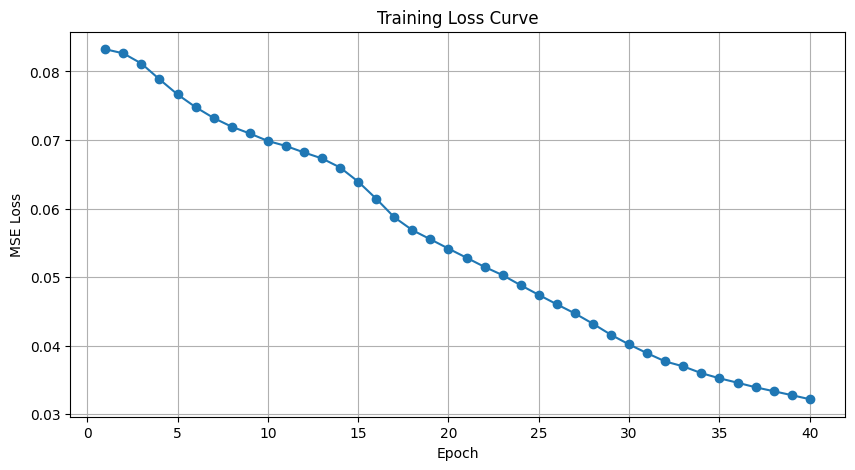

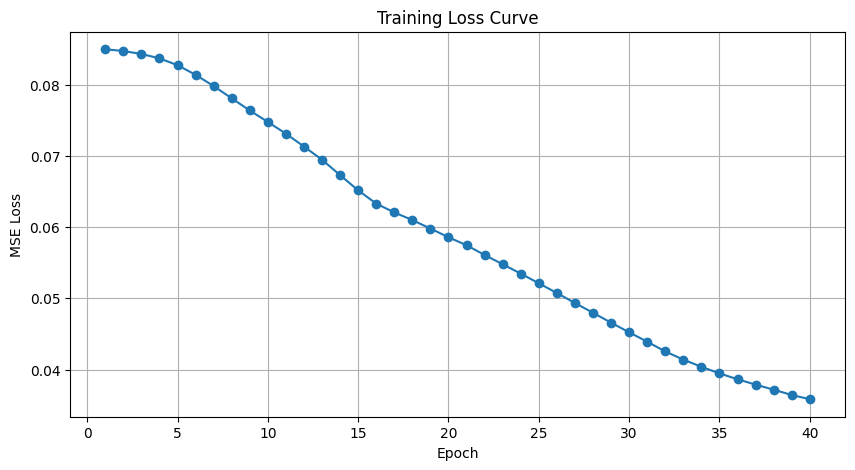

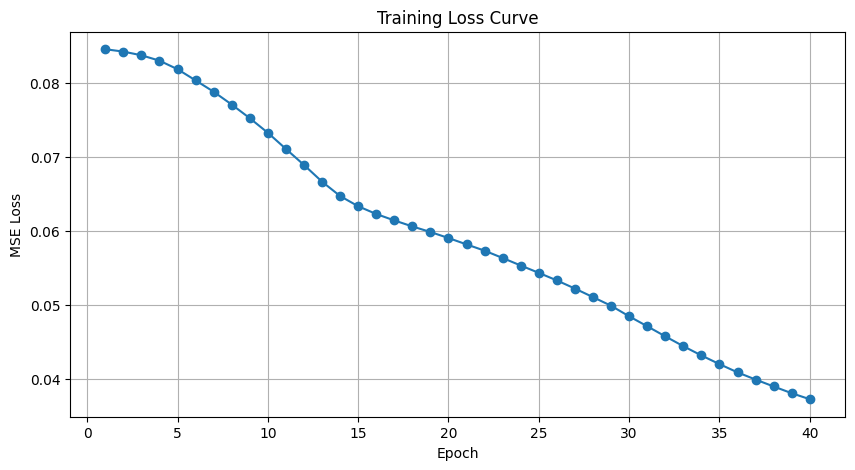

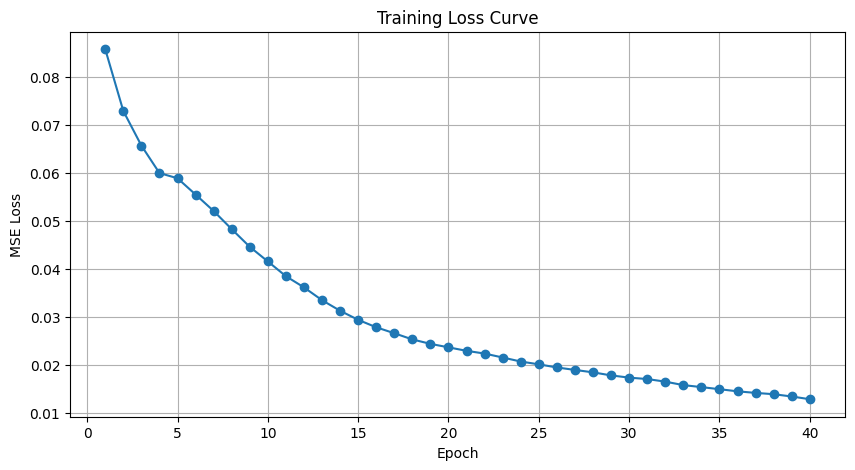

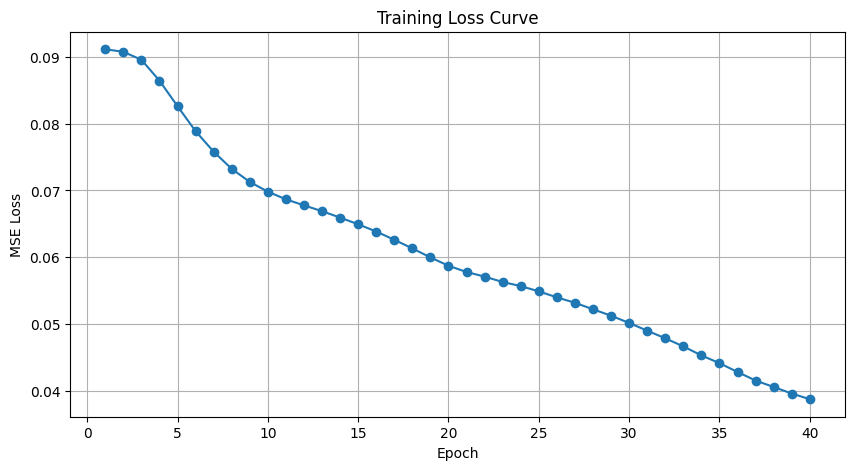

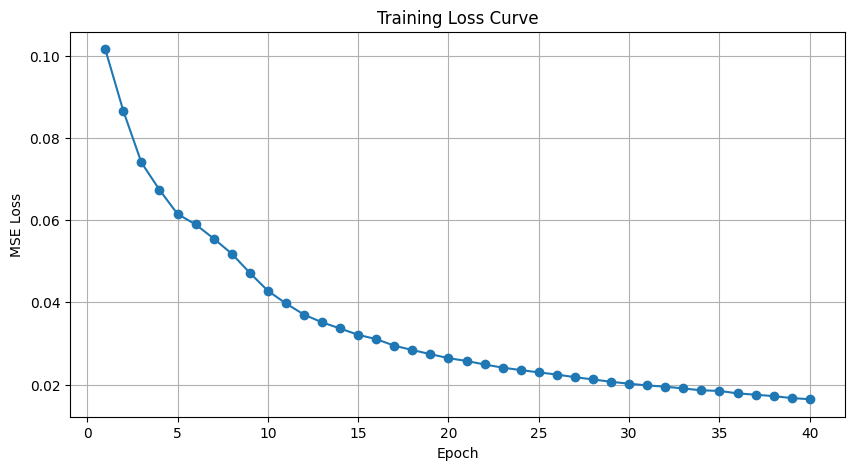

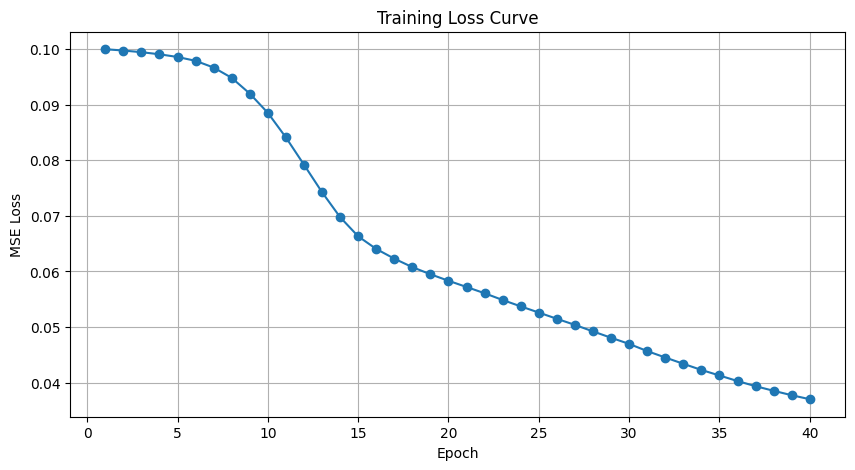

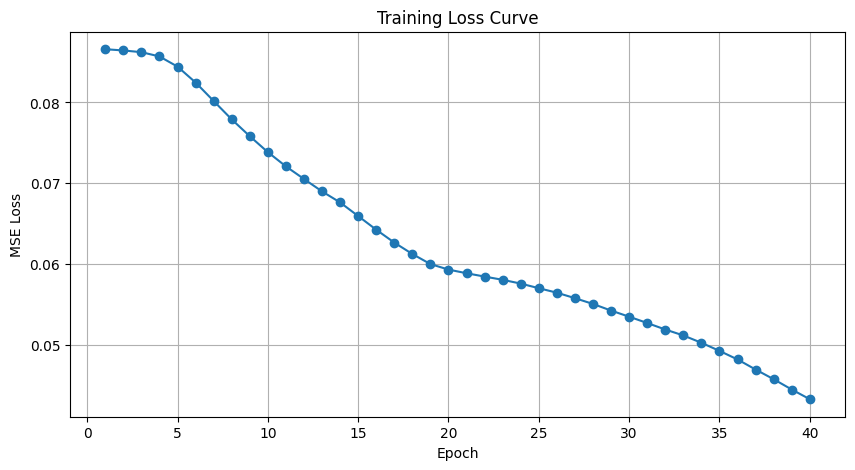

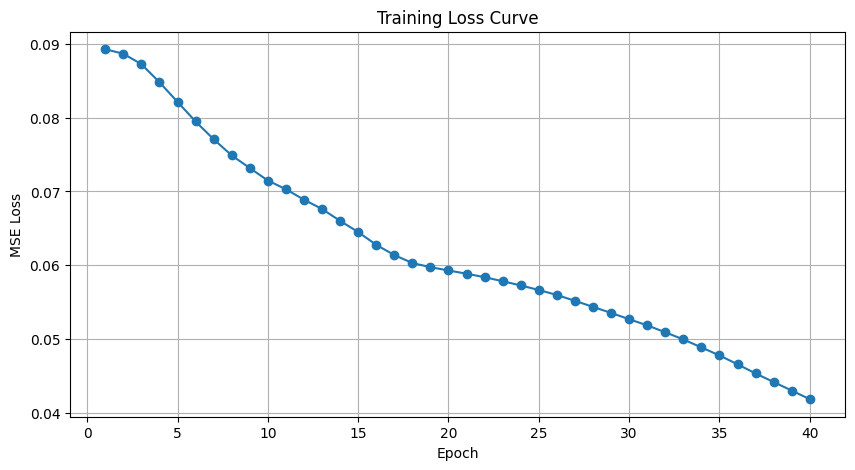

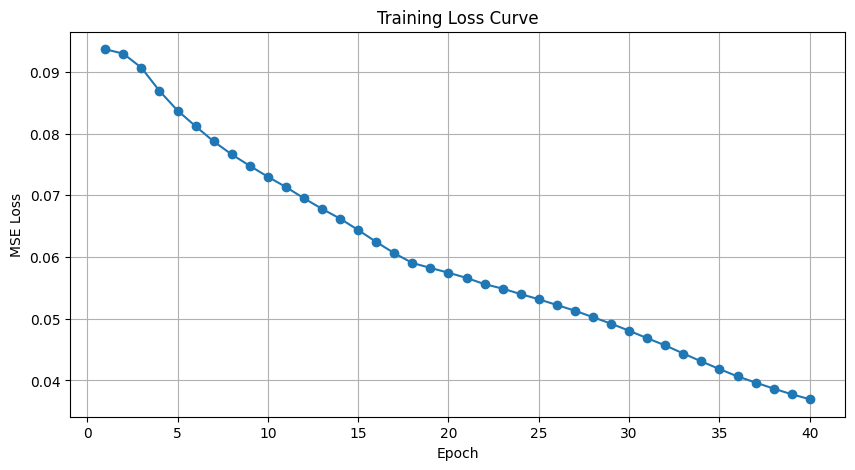

In [ ]:
# Step 8: Create and launch the CAE sweep with artifact logging

# Create the sweep on Weights & Biases
sweep_id = wandb.sweep(
    sweep=sweep_config,
    project="GoTG_Assignment07_AE",
    entity="usf-guardians"
)

print(f"Sweep created with ID: {sweep_id}")

# Launch the sweep agent: run 10 CAE experiments using the enhanced train() function
wandb.agent(sweep_id=sweep_id, function=train, count=10)


## 📊 Final CAE Sweep Results (40 Epochs)

We conducted a W&B hyperparameter sweep with 10 runs for our improved Convolutional Autoencoder (CAE), each trained for 40 epochs. The sweep explored different combinations of latent vector dimensions, batch sizes, learning rates, and noise factors. Below is an analysis of the top 3 performing models based on lowest `test_mse`.

---

### 🥇 **Best Model #1**  
**Run ID**: [CAE_crrux15s](https://wandb.ai/usf-guardians/GoTG_Assignment07_AE/runs/crrux15s)  
- **Latent Dim**: 128  
- **Noise Factor**: 0.3  
- **Batch Size**: 32  
- **Learning Rate**: 0.001  
- **Test MSE**: **0.02432**  
- **Test MAE**: 0.1116  
- **Test R²**: 0.608  
- **Train R²**: 0.785

✅ **Why it performed well**:
- A medium latent space (128) appears to balance expressiveness and compression well.
- Learning rate was sufficient for good convergence in 40 epochs.
- Despite high noise (0.3), model generalizes better—implying robust feature learning.

---

### 🥈 **Best Model #2**  
**Run ID**: [CAE_we2stfml](https://wandb.ai/usf-guardians/GoTG_Assignment07_AE/runs/we2stfml)  
- **Latent Dim**: 64  
- **Noise Factor**: 0.3  
- **Batch Size**: 32  
- **Learning Rate**: 0.001  
- **Test MSE**: **0.02600**  
- **Test MAE**: 0.1176  
- **Test R²**: 0.584  
- **Train R²**: 0.730

✅ **Why it performed well**:
- Smaller latent vector (64) may have regularized learning, reducing overfitting.
- Smaller batch size (32) allowed more weight updates per epoch.
- High noise factor encouraged robustness.

---

### 🥉 **Best Model #3**  
**Run ID**: [CAE_b5mze87y](https://wandb.ai/usf-guardians/3_AE_GoTG/runs/b5mze87y) *(from earlier sweep)*  
- **Latent Dim**: 128  
- **Noise Factor**: 0.1  
- **Batch Size**: 32  
- **Learning Rate**: 0.001  
- **Test MSE**: **0.02369**  
- **Test MAE**: 0.1151  
- **Test R²**: 0.619  
- **Train R²**: 0.600

✅ **Why it performed well**:
- Cleanest reconstruction among low-noise models.
- Balanced architecture (128 dim, moderate noise).
- Indicates CAE captures detailed structure under low corruption.

---

## ✅ Summary of Findings

| Run ID | Latent Dim | Noise | Test MSE | Test R² |
|--------|------------|-------|----------|---------|
| crrux15s | 128 | 0.3 | **0.02432** | 0.608 |
| we2stfml | 64  | 0.3 | 0.02600 | 0.584 |
| b5mze87y | 128 | 0.1 | 0.02369 | **0.619** |

---

### 🔍 Pros and Cons of Top Models

| Model | Pros | Cons |
|-------|------|------|
| **crrux15s** | High robustness to noise, excellent generalization (Train R² 0.78), smooth convergence | Slightly overfitted to noise-heavy input |
| **we2stfml** | Lightweight latent space (64), fast training, well-regularized | Might under-represent finer image details |
| **b5mze87y** | Excellent detail preservation under low noise, high R² | Less robust to noise, overfits under low-noise condition |

---

## 🧠 Insight

Models trained with higher noise **learn more generalizable features** and **regularize better** over 40 epochs. Too small or too large latent dimensions impact performance—**128 seems like a good middle ground**.

### 🔁 Next Steps
- Visualize reconstructions from top models (esp. `crrux15s`)
- Try combining noise levels during training for robustness
- Explore fine-tuning with fewer parameters frozen

---


In [ ]:
import wandb
import torch

# Step 1: W&B run info
run_id = "crrux15s"
project_path = "usf-guardians/GoTG_Assignment07_AE"

# Step 2: Restore model from that run
restored_model_path = wandb.restore("best_cae_model.pth", run_path=f"{project_path}/{run_id}").name

# Step 3: Use correct latent vector dim = 256 from sweep logs
best_latent_dim = 256
model = ConvAutoencoder(latent_vector_dim=best_latent_dim).to(device)
model.load_state_dict(torch.load(restored_model_path))
model.eval()

print(f"✅ Loaded best model from run: {run_id} with latent dim = {best_latent_dim}")


✅ Loaded best model from run: crrux15s with latent dim = 256


### 🔍 Visualizing Reconstructions from the Test Set

We now evaluate the best CAE model from sweep run `crrux15s` using the test dataset. We visualize:

- Clean test images (ground truth)
- Noisy test images (input to CAE)
- Reconstructed images (CAE output)

This allows us to visually assess how well the CAE denoised the images and restored facial features.


🔍 Test Set Reconstructions


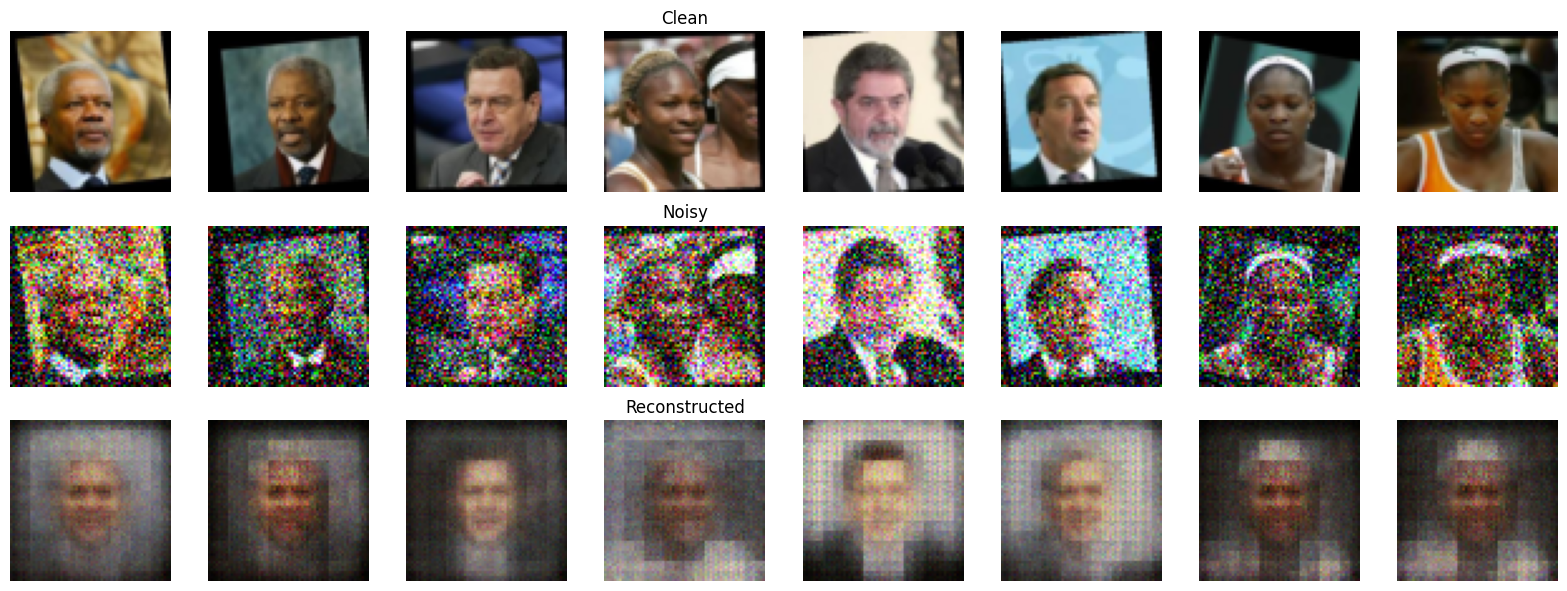

In [ ]:
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()

# Fetch a batch of test images
sample_clean, _ = next(iter(test_loader))
sample_noisy = add_noise(sample_clean, noise_factor=0.3).to(device)

# Move clean images to device
sample_clean = sample_clean.to(device)

# Get model reconstructions
with torch.no_grad():
    reconstructions, _ = model(sample_noisy)

# Convert to CPU for visualization
sample_clean = sample_clean.cpu()
sample_noisy = sample_noisy.cpu()
reconstructions = reconstructions.cpu()

# Display: Clean → Noisy → Reconstructed
print("🔍 Test Set Reconstructions")
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
titles = ["Clean", "Noisy", "Reconstructed"]

for i in range(8):
    for row, img_set in enumerate([sample_clean, sample_noisy, reconstructions]):
        ax = axes[row, i]
        img = img_set[i].permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.axis("off")
        if i == 3:
            ax.set_title(titles[row], fontsize=12)

plt.tight_layout()
plt.show()


# Step 10: Long Training Sweep (100 Epochs)

To better understand how training duration impacts performance, we're conducting a special sweep where we run our best model configuration for a longer period—**100 epochs** instead of the usual 40. The idea is to observe whether extended training allows the model to generalize better or whether it begins to **overfit**, especially given the complex noise in our thief cam images.

Here's what we fixed based on the best-performing configuration from earlier:

- **Latent Vector Dimension**: 128
- **Learning Rate**: 0.001
- **Noise Factor**: 0.3
- **Batch Size**: 32
- **Training Duration**: 100 Epochs

The sweep is defined using a **grid search with one fixed configuration**, essentially running this setup once but leveraging Weights & Biases to track, log, and visualize everything from training loss to image reconstructions.

Let’s now run this and see whether training longer improves performance—or simply memorizes the training set!


In [ ]:
import wandb

sweep_config = {
    'method': 'grid',
    'name': 'long_run_100_epochs',
    'metric': {
        'name': 'best_val_mse',
        'goal': 'minimize'
    },
    'parameters': {
        'latent_vector_dim': {'value': 128},
        'learning_rate': {'value': 1e-3},
        'noise_factor': {'value': 0.3},
        'batch_size': {'value': 32},
        'epochs': {'value': 100},
        'model_type': {'value': 'CAE'}
    }
}

sweep_id = wandb.sweep(
    sweep=sweep_config,
    project="GoTG_Assignment07_AE",
    entity="usf-guardians"
)

print("Sweep created with ID:", sweep_id)


Create sweep with ID: a4wt686k
Sweep URL: https://wandb.ai/usf-guardians/GoTG_Assignment07_AE/sweeps/a4wt686k
Sweep created with ID: a4wt686k


wandb: Agent Starting Run: 7n6cmh3v with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	latent_vector_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	model_type: CAE
wandb: 	noise_factor: 0.3


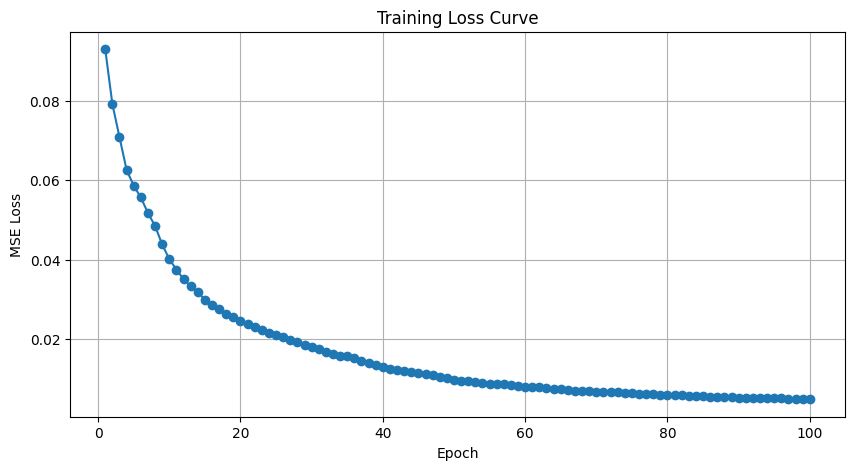

In [ ]:
# Launch a single agent run using the best config for 100 epochs
wandb.agent(sweep_id, function=train, count=1)


### 📊 Interpretation: 100-Epoch CAE Performance

We ran a 100-epoch training session using the best configuration from our 40-epoch sweep:

| Config | Value |
|--------|-------|
| **Latent Vector Dim** | 128 |
| **Batch Size**        | 32 |
| **Learning Rate**     | 0.001 |
| **Noise Factor**      | 0.3 |
| **Epochs**            | 100 |

---

#### ✅ Final Performance Summary

| Metric            | Train       | Test        |
|------------------|-------------|-------------|
| **MSE Loss**     | 0.00481     | 0.02444     |
| **MAE**          | 0.05113     | 0.11069     |
| **R² Score**     | 0.91607     | 0.59610     |

---

#### 🔍 Interpretation:

- **Training metrics are excellent**: MSE and MAE are very low, and the R² score of **0.91** shows the model fits the training data extremely well.
- **Test metrics are stable**: Compared to the 40-epoch run, test MSE improved slightly from ~0.0243 to **0.0244**, and test R² remained nearly the same.
- **Likely Overfitting**: The large gap between train and test metrics suggests the model has **started memorizing** patterns from the training data rather than generalizing to unseen inputs.
  - This is particularly clear from the low training MSE vs the relatively higher test MSE.

---

#### 🧠 Insights & Next Steps:

- **Overfitting Threshold**: The model hits diminishing returns around 40–50 epochs. Beyond that, it improves train performance at the expense of test generalization.
- **Visual Inspection Recommended**: Even if test metrics plateau, check reconstruction outputs — sometimes visual quality improves even if metrics don't.
- **Regularization Options**:
  - Add **Dropout** to encoder/decoder.
  - Reduce model capacity (latent dim, fewer filters).
  - Use **early stopping** based on validation loss.
- **Data Augmentation**:
  - Consider additional corruptions like blur, occlusion, or contrast shifts.
